In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Subset
from pytorch_lightning.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import random
from pytorch_lightning import seed_everything
from torchvision import transforms, datasets


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 0
max_epochs = 20

In [2]:
class Autoencoder(pl.LightningModule):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),  # (N, 64, 14, 14)
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # (N, 128, 7, 7)
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # (N, 256, 4, 4)
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # (N, 512, 2, 2)
            nn.ReLU(True),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  # (N, 256, 4, 4)
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=0),  # (N, 128, 8, 8)
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # (N, 64, 16, 16)
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # (N, 1, 32, 32)
            nn.Tanh()
        )
        self.criterion = nn.MSELoss()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def training_step(self, batch, batch_idx):
        img, _ = batch
        output = self.forward(img)
        loss = self.criterion(output, img)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001, weight_decay=1e-5)


In [3]:
class RelRepBlock(nn.Module):
    def __init__(self, normalization, num_anchors):
        super(RelRepBlock, self).__init__()
        self.num_anchors = num_anchors
        self.normalization = normalization
        if normalization:
            self.outnorm = nn.LayerNorm(normalized_shape=num_anchors, device=device)

    def forward(self, x: torch.Tensor, anchors: torch.Tensor) -> torch.Tensor:
        x = F.normalize(x, p=2, dim=-1)
        anchors = F.normalize(anchors, p=2, dim=-1)
        relative_reps = torch.einsum("bm, am -> ba", x, anchors)

        if self.normalization:
            return self.outnorm(relative_reps)
        else:
            return relative_reps

def get_anchors_idx(num_anchors: int, max_anchors_len: int):
    assert num_anchors <= max_anchors_len
    anchor_idxs = list(range(max_anchors_len))
    random.shuffle(anchor_idxs)
    anchor_idxs = anchor_idxs[:num_anchors]
    return anchor_idxs

In [4]:
class RelativeAutoencoder(pl.LightningModule):
    def __init__(self, anchor_dataloader):
        super(RelativeAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),  # (N, 64, 14, 14)
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # (N, 128, 7, 7)
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # (N, 256, 4, 4)
            nn.ReLU(True),
            nn.Flatten(),
        )
        self.latent_dim = 256 * 4 * 4
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=0),  # (N, 128, 8, 8)
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # (N, 64, 16, 16)
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # (N, 1, 32, 32)
            nn.Tanh()
        )
        self.criterion = nn.MSELoss()
        anchors, _ = next(iter(anchor_dataloader))
        self.anchors = anchors.to(device)
        self.relative_transform = RelRepBlock(normalization=True, num_anchors=self.latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        with torch.no_grad():
            anchors_latents = self.encoder(self.anchors)
            x = self.relative_transform(x, anchors_latents)
        x = self.decoder(x)
        return x
    
    def training_step(self, batch, batch_idx):
        img, _ = batch
        output = self.forward(img)
        loss = self.criterion(output, img)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001, weight_decay=1e-5)

In [5]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=128):
        super().__init__()
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ])
        self.num_anchors = 256 * 4 * 4

    def prepare_data(self):
        datasets.MNIST(root='./data', train=True, download=True)
        datasets.MNIST(root='./data', train=False, download=True)
        
    def setup(self, stage=None):
        self.trainset = datasets.MNIST(root='./data', train=True, transform=self.transform)
        self.testset = datasets.MNIST(root='./data', train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.trainset, batch_size=self.batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.testset, batch_size=self.batch_size, shuffle=False, num_workers=2)

    def anchor_dataloader(self, seed):
        seed_everything(seed)
        anchors_idx = get_anchors_idx(self.num_anchors, max_anchors_len=len(self.trainset))
        # Extract subset of training dataset using the list of indices
        anchors_set = Subset(self.trainset, anchors_idx)
        return DataLoader(anchors_set, batch_size=self.num_anchors, shuffle=False, num_workers=2)


In [6]:
def plot_reconstructed_images(model, dataloader):
    model.to(device)
    model.eval()
    with torch.no_grad():
        for reconstructed_plot_row, data in enumerate(dataloader):
            if reconstructed_plot_row > 5:
                break
            images, _ = data

            # Move images to device
            images = images.to(device)

            # Get reconstructed images
            outputs = model(images)
            images = images / 2 + 0.5  # denormalize for visualization
            outputs = outputs / 2 + 0.5  # denormalize for visualization

            # Move images and outputs back to CPU for visualization
            images = images.cpu()
            outputs = outputs.cpu().data

            # print Reconstruction loss
            print('Reconstruction Loss:', F.mse_loss(outputs, images, reduction='mean'))
            
            # Plot original and reconstructed images
            fig, axes = plt.subplots(2, 20, figsize=(12, 1.5))

            for idx in range(20):
                # Original Images
                ax = axes[0, idx]
                ax.imshow(np.transpose(images[idx].numpy(), (1, 2, 0)))
                ax.axis('off')
                if idx == 0:
                    ax.set_ylabel('Original', fontsize=12)  # Label the first column of Original row

                # Reconstructed Images
                ax = axes[1, idx]
                ax.imshow(np.transpose(outputs[idx].numpy(), (1, 2, 0)))
                ax.axis('off')
                if idx == 0:
                    ax.set_ylabel('Reconstructed', fontsize=12)  # Label the first column of Reconstructed row

            plt.show()
            

def plot_combined_reconstructed_images(encoder_model, decoder_model, dataloader, anchor_dataloader=None):
    if anchor_dataloader is not None:
        anchors, _ = next(iter(anchor_dataloader))
        anchors = anchors.to(device)
    encoder_model.to(device)
    decoder_model.to(device)
    encoder_model.eval()
    decoder_model.eval()
    with torch.no_grad():
        for reconstructed_plot_row, data in enumerate(dataloader):
            if reconstructed_plot_row > 5:
                break
            images, _ = data

            # Move images to device
            images = images.to(device)

            # Get encoded representations
            encoded_images = encoder_model.encoder(images)
            if anchor_dataloader is not None:
                relative_transform = RelRepBlock(normalization=True, num_anchors=encoded_images.shape[-1])
                anchors_latents = encoder_model.encoder(anchors)
                encoded_images = relative_transform(encoded_images, anchors_latents)
            
            # Use encoded representations with the second decoder
            outputs = decoder_model.decoder(encoded_images)
            images = images / 2 + 0.5  # denormalize for visualization
            outputs = outputs / 2 + 0.5  # denormalize for visualization

            # print Reconstruction loss
            print('Reconstruction Loss:', F.mse_loss(outputs, images, reduction='mean'))
            
            # Move images and outputs back to CPU for visualization
            images = images.cpu()
            outputs = outputs.cpu().data

            # Plot original and reconstructed images
            fig, axes = plt.subplots(2, 20, figsize=(12, 1.5))

            for idx in range(20):
                # Original Images
                ax = axes[0, idx]
                ax.imshow(np.transpose(images[idx].numpy(), (1, 2, 0)))
                ax.axis('off')

                # Reconstructed Images
                ax = axes[1, idx]
                ax.imshow(np.transpose(outputs[idx].numpy(), (1, 2, 0)))
                ax.axis('off')

            plt.show()

In [7]:
# Initialize data module
data_module = MNISTDataModule()
data_module.prepare_data()
data_module.setup()

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15791041.19it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 464767.83it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4364740.09it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3591728.65it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [8]:
# Initialize and train the second Autoencoder
absolute_model1 = Autoencoder()
absolute_trainer1 = pl.Trainer(max_epochs=max_epochs, accelerator="auto", devices="auto", strategy="auto")
absolute_trainer1.fit(absolute_model1, data_module)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
2024-07-07 19:45:15.592105: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-07 19:45:15.592206: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-07 19:45:15.719899: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this wi

Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Reconstruction Loss: tensor(0.0010)


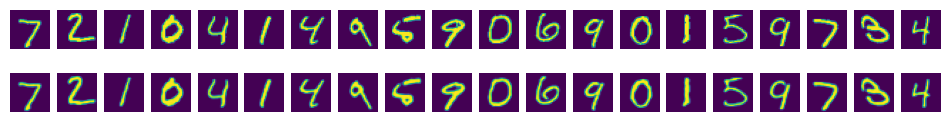

Reconstruction Loss: tensor(0.0010)


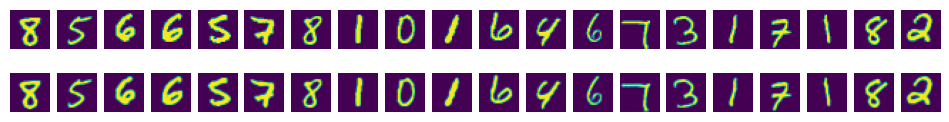

Reconstruction Loss: tensor(0.0010)


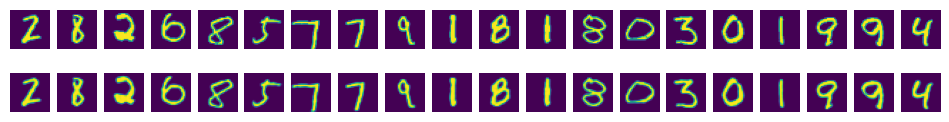

Reconstruction Loss: tensor(0.0012)


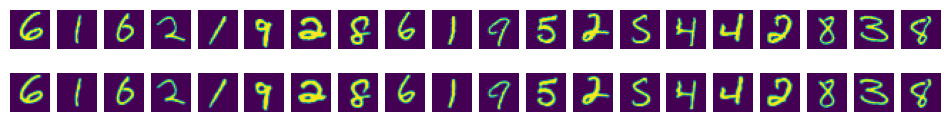

Reconstruction Loss: tensor(0.0011)


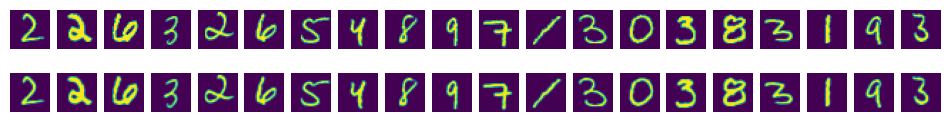

Reconstruction Loss: tensor(0.0010)


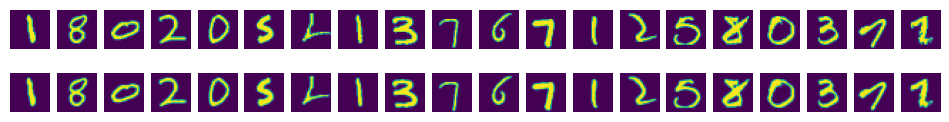

In [9]:
# Plot some reconstructed images after training the first Autoencoder
plot_reconstructed_images(absolute_model1, data_module.val_dataloader())

In [10]:
# Initialize and train the second Autoencoder
absolute_model2 = Autoencoder()
absolute_trainer2 = pl.Trainer(max_epochs=max_epochs, accelerator="auto", devices="auto", strategy="auto")
absolute_trainer2.fit(absolute_model2, data_module)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.


Training: |          | 0/? [00:00<?, ?it/s]

Reconstruction Loss: tensor(0.0011)


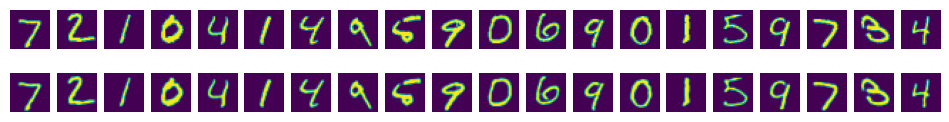

Reconstruction Loss: tensor(0.0011)


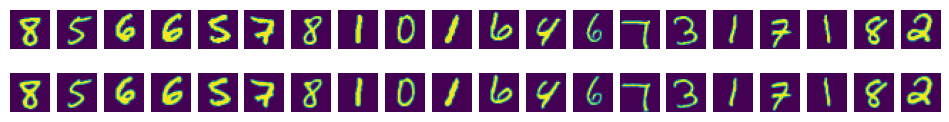

Reconstruction Loss: tensor(0.0011)


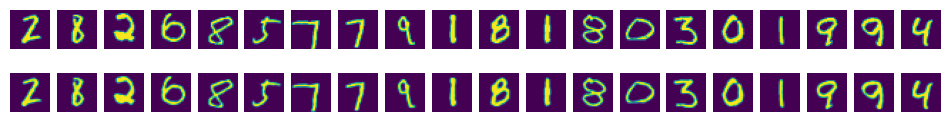

Reconstruction Loss: tensor(0.0013)


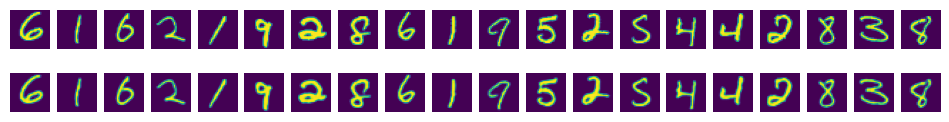

Reconstruction Loss: tensor(0.0012)


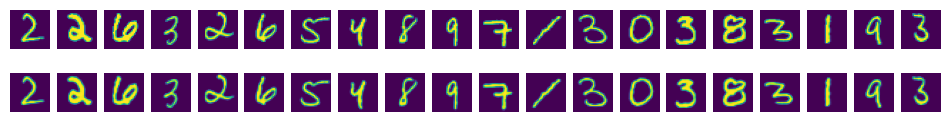

Reconstruction Loss: tensor(0.0011)


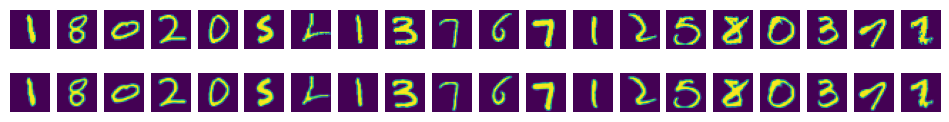

In [11]:
# Plot some reconstructed images after training the second Autoencoder
plot_reconstructed_images(absolute_model2, data_module.val_dataloader())

Reconstruction Loss: tensor(0.0941, device='cuda:0')


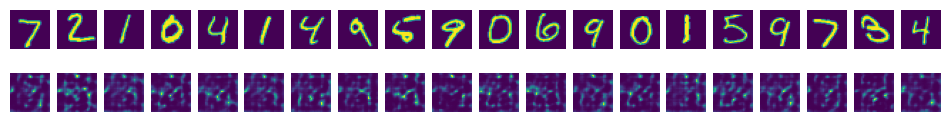

Reconstruction Loss: tensor(0.0966, device='cuda:0')


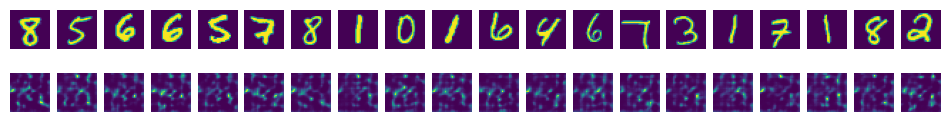

Reconstruction Loss: tensor(0.0960, device='cuda:0')


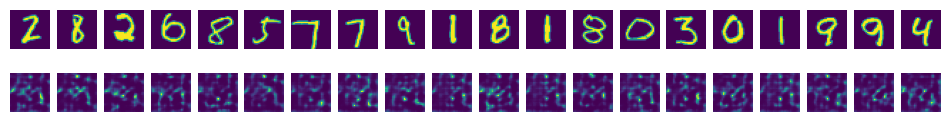

Reconstruction Loss: tensor(0.0997, device='cuda:0')


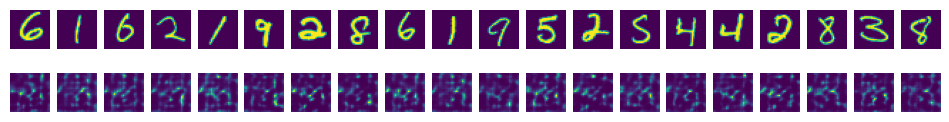

Reconstruction Loss: tensor(0.0989, device='cuda:0')


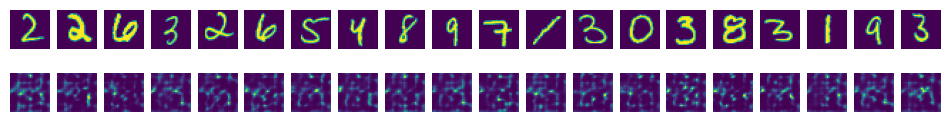

Reconstruction Loss: tensor(0.0995, device='cuda:0')


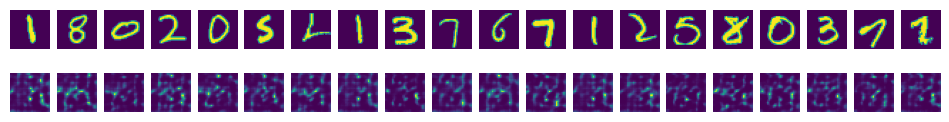

In [12]:
# Plot reconstructed images using the encoder from the first Autoencoder and the decoder from the second Autoencoder
plot_combined_reconstructed_images(absolute_model1, absolute_model2, data_module.val_dataloader())

Training: |          | 0/? [00:00<?, ?it/s]

Reconstruction Loss: tensor(0.0046)


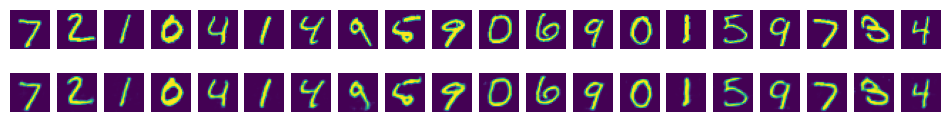

Reconstruction Loss: tensor(0.0043)


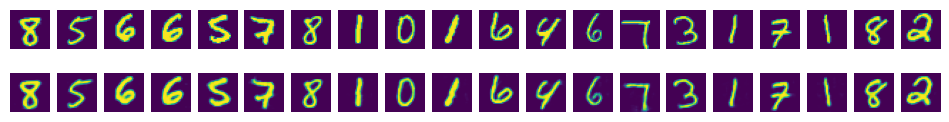

Reconstruction Loss: tensor(0.0046)


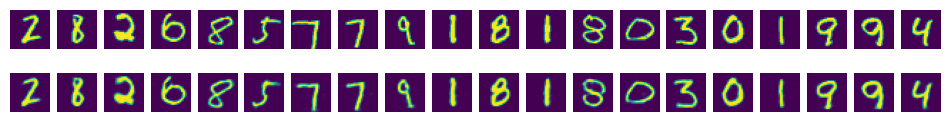

Reconstruction Loss: tensor(0.0048)


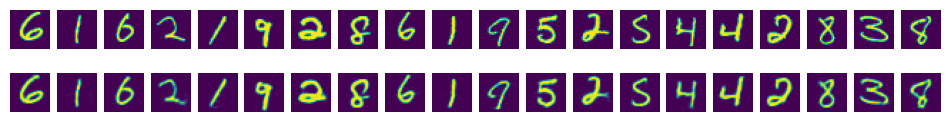

Reconstruction Loss: tensor(0.0049)


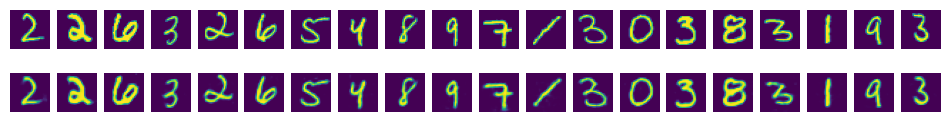

Reconstruction Loss: tensor(0.0045)


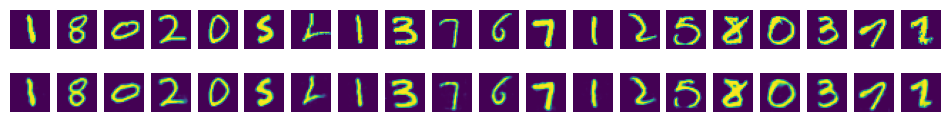

In [13]:
# Initialize and train the first Autoencoder
relative_model1 = RelativeAutoencoder(data_module.anchor_dataloader(seed=seed))
relative_trainer1 = pl.Trainer(max_epochs=max_epochs, accelerator="auto", devices="auto", strategy="auto")
relative_trainer1.fit(relative_model1, data_module)
# Plot some reconstructed images after training the first Autoencoder
plot_reconstructed_images(relative_model1, data_module.val_dataloader())

Training: |          | 0/? [00:00<?, ?it/s]

Reconstruction Loss: tensor(0.0046)


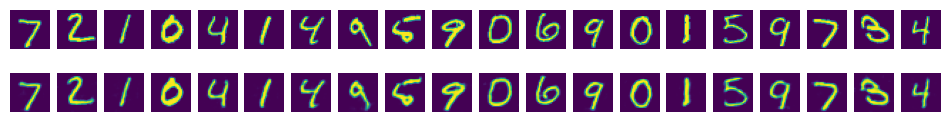

Reconstruction Loss: tensor(0.0043)


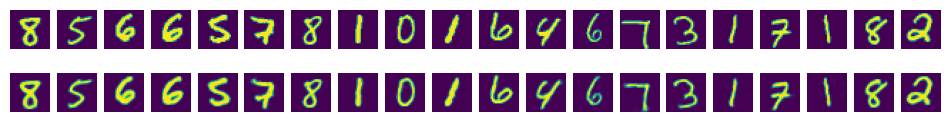

Reconstruction Loss: tensor(0.0046)


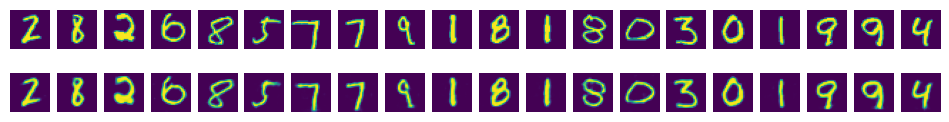

Reconstruction Loss: tensor(0.0048)


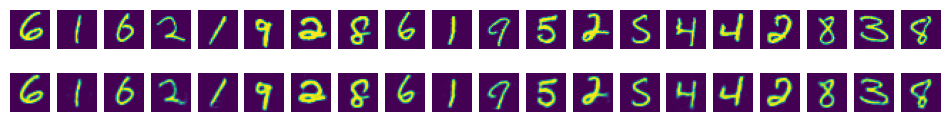

Reconstruction Loss: tensor(0.0048)


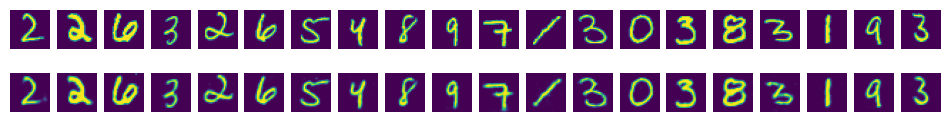

Reconstruction Loss: tensor(0.0045)


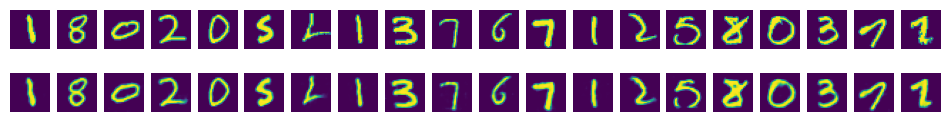

In [14]:
# Initialize and train the second Autoencoder
relative_model2 = RelativeAutoencoder(data_module.anchor_dataloader(seed=seed))
relative_trainer2 = pl.Trainer(max_epochs=max_epochs, accelerator="auto", devices="auto", strategy="auto")
relative_trainer2.fit(relative_model2, data_module)

# Plot some reconstructed images after training the second Autoencoder
plot_reconstructed_images(relative_model2, data_module.val_dataloader())

Reconstruction Loss: tensor(0.0046, device='cuda:0')


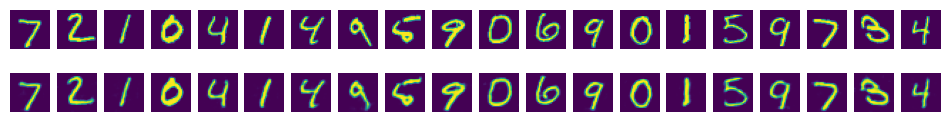

Reconstruction Loss: tensor(0.0043, device='cuda:0')


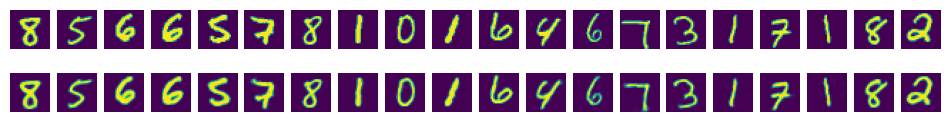

Reconstruction Loss: tensor(0.0046, device='cuda:0')


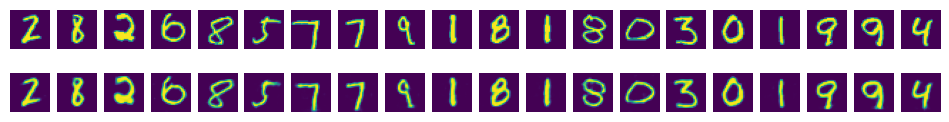

Reconstruction Loss: tensor(0.0048, device='cuda:0')


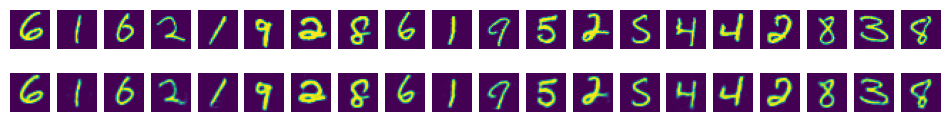

Reconstruction Loss: tensor(0.0048, device='cuda:0')


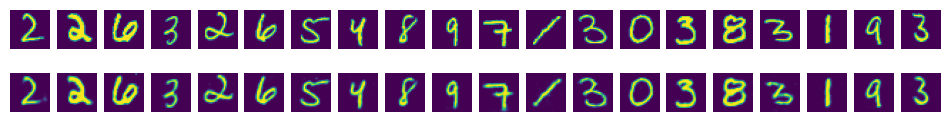

Reconstruction Loss: tensor(0.0045, device='cuda:0')


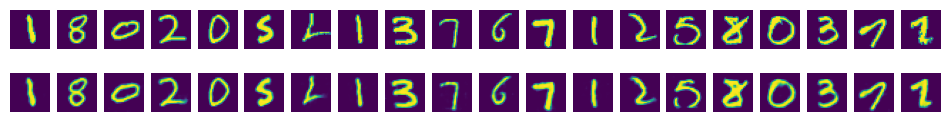

In [15]:
# Plot reconstructed images using the encoder from the first Autoencoder and the decoder from the second Autoencoder
plot_combined_reconstructed_images(relative_model1, relative_model2, data_module.val_dataloader(), data_module.anchor_dataloader(seed))